## Data preparation

In [1]:
import pandas as pd
import json
import mplfinance as mpl
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(7)

2022-04-03 17:26:51.407953: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-03 17:26:51.408004: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
with open('./Training data/googl.json') as f:
    data = json.load(f)
raw_df = pd.DataFrame(data["Weekly Time Series"]).T
raw_df = raw_df.rename(lambda x: x.split(' ')[1], axis=1)
for c in raw_df.columns:
    raw_df[c] = pd.to_numeric(raw_df[c])
raw_df.index = pd.to_datetime(raw_df.index)
raw_df = raw_df.sort_index()
raw_df

,open,high,low,close,volume
2004-08-27,110.7600,113.4800,103.5700,106.15,55998500
2004-09-03,105.2800,105.4900,98.9400,100.01,39523700
2004-09-10,101.0100,106.5600,99.6100,105.33,23593600
2004-09-17,106.6300,117.4900,106.4600,117.49,48124800
2004-09-24,116.9500,124.1000,116.7700,119.83,43097600
...,...,...,...,...,...
2022-02-25,2596.7618,2705.4300,2499.0650,2689.19,8405453
2022-03-04,2661.0000,2728.7899,2606.7500,2638.13,7196673
2022-03-11,2629.7600,2675.9100,2513.4937,2597.41,9059664
2022-03-18,2605.0000,2724.8800,2505.5000,2722.51,8882203


## Baseline model

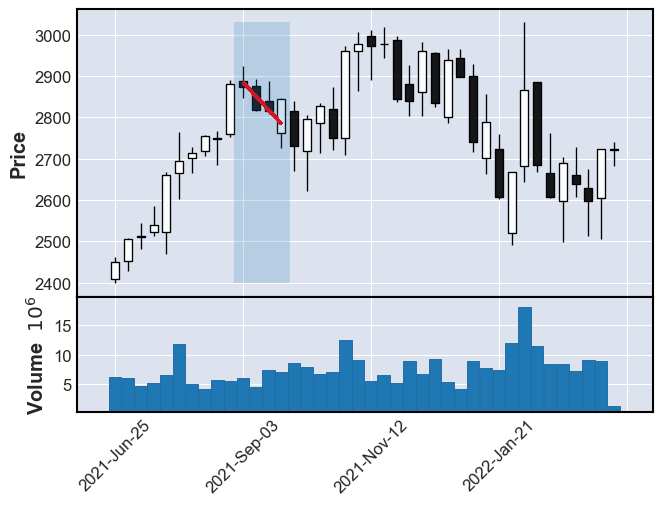

In [3]:
mpl.plot(raw_df[-40:], type='candle', volume=True, vlines=dict(vlines='2021-09-11',linewidths=40,alpha=0.2), alines=dict(alines=[('2021-09-3', 2885),('2021-09-24',2785)], colors='r'))

accuracy 38.88888888888889%


/tmp/ipykernel_7457/486195391.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


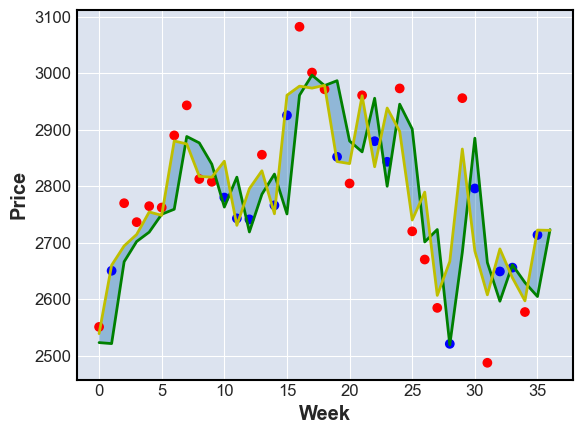

In [4]:
def simple_predictions(df):
    success = 0
    forecast = []
    for x in range(3, len(df)-1):
        interpolate = interp1d(range(4), [(df.iloc[row]['open'] + df.iloc[row]['close']) / 2 for row in range(x-3, x+1)], kind='slinear', fill_value='extrapolate', bounds_error=False)
        forecast.append(t:=interpolate(4))
        if  df.iloc[x+1]['open'] <= t <= df.iloc[x+1]['close'] or df.iloc[x+1]['open'] >= t >= df.iloc[x+1]['close']:
            success += 1
    print(f'accuracy {success/(len(df)-4)*100}%')
    fig, ax = plt.subplots()
    ax.fill_between(range(0, len(df)-3), df['open'][3:], df['close'][3:], alpha=0.4)
    ax.plot(range(0, len(df)-3), df['open'][3:], color='g')
    ax.plot(range(0, len(df)-3), df['close'][3:], color='y')
    ax.scatter(range(0, len(df)-4), forecast, c=np.array([[0., 0., 1.] if df.iloc[3 + i]['open'] <= forecast[i] <= df.iloc[3+i]['close'] or df.iloc[3+i]['open'] >= forecast[i] >= df.iloc[3+i]['close'] else [1., 0., 0.] for i in range(len(forecast))]))
    ax.set_xlabel('Week')
    ax.set_ylabel('Price')
    fig.show()
    
simple_predictions(raw_df[-40:])

## First nerual network model

In [5]:
with open('./Training data/googl-daily.json') as f:
    data = json.load(f)
raw_df = pd.DataFrame(data["Time Series (Daily)"]).T
raw_df = raw_df.rename(lambda x: x.split(' ')[1], axis=1)
for c in raw_df.columns:
    raw_df[c] = pd.to_numeric(raw_df[c])
raw_df.index = pd.to_datetime(raw_df.index)
raw_df = raw_df.sort_index()
raw_df

,open,high,low,close,volume
2004-08-19,100.01,104.0600,95.960,100.335,44659000
2004-08-20,101.01,109.0800,100.500,108.310,22834300
2004-08-23,110.76,113.4800,109.050,109.400,18256100
2004-08-24,111.24,111.6000,103.570,104.870,15247300
2004-08-25,104.76,108.0000,103.880,106.000,9188600
...,...,...,...,...,...
2022-03-24,2784.00,2832.3750,2755.010,2831.440,1319828
2022-03-25,2838.32,2840.7000,2794.750,2833.460,1204457
2022-03-28,2818.01,2840.0500,2796.225,2829.110,1752463
2022-03-29,2852.95,2875.8700,2840.765,2850.110,1715851


In [59]:
inputs = keras.Input(shape=(5,))
x = keras.layers.Dense(5, activation="relu")(inputs)
x = keras.layers.Dense(6, activation="relu")(x)
x = keras.layers.Dense(3, activation="relu")(x)
output = keras.layers.Dense(1, activation="linear")(x)
model = keras.Model(inputs=inputs, outputs=output, name="perceptronMulticapa")
model.summary()

Model: "perceptronMulticapa"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_11 (Dense)            (None, 5)                 30        
                                                                 
 dense_12 (Dense)            (None, 6)                 36        
                                                                 
 dense_13 (Dense)            (None, 3)                 21        
                                                                 
 dense_14 (Dense)            (None, 1)                 4         
                                                                 
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [7]:
def custom_loss_ruben(actual, prediction):
    #if actual[1] < actual[0]:
        return tf.multiply(tf.divide(1, tf.divide(tf.add(actual[0], actual[1]), tf.subtract(2,actual[1]))), tf.abs(tf.divide(tf.subtract(prediction,tf.add(actual[0], actual[1])), 2)))
    #else:
       #return tf.constant((1 / ((actual[1]+actual[0])/2-actual[0])) * np.abs(prediction-(actual[1]+actual[0])/2))

In [60]:
df = raw_df[:len(raw_df)-1].to_numpy() #take out the last data point since we dont have future data to validate predictions
y_df = np.array([(row[0]+row[1])/2 for row in df[1:, [0, 3]]])
x_df = df[:-1]
x_train = x_df[:-100] 
y_train = y_df[:-100]
x_test = x_df[-100:]
y_test = df[1:, [0, 3]][-100:]
x_train.shape

(4333, 5)

In [61]:
tf.random.set_seed(7)
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
)
history = model.fit(
    x_train[:-100], y_train[:-100],
    validation_data=(x_train[-100:], y_train[-100:]), 
    batch_size=3, epochs=50, shuffle=False, 
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

Epoch 1/50
1411/1411 [==============================] - 3s 2ms/step - loss: 508505620480.0000 - val_loss: 11340809216.0000
Epoch 2/50
1411/1411 [==============================] - 2s 1ms/step - loss: 432492445696.0000 - val_loss: 9248078848.0000
Epoch 3/50
1411/1411 [==============================] - 2s 1ms/step - loss: 347657240576.0000 - val_loss: 7379154432.0000
Epoch 4/50
1411/1411 [==============================] - 2s 1ms/step - loss: 273369169920.0000 - val_loss: 5771514880.0000
Epoch 5/50
1411/1411 [==============================] - 2s 2ms/step - loss: 210047483904.0000 - val_loss: 4408257536.0000
Epoch 6/50
1411/1411 [==============================] - 2s 2ms/step - loss: 156903784448.0000 - val_loss: 3268844032.0000
Epoch 7/50
1411/1411 [==============================] - 2s 2ms/step - loss: 113074577408.0000 - val_loss: 2333893376.0000
Epoch 8/50
1411/1411 [==============================] - 2s 2ms/step - loss: 78920589312.0000 - val_loss: 1646660352.0000
Epoch 9/50
1411/1411 [==

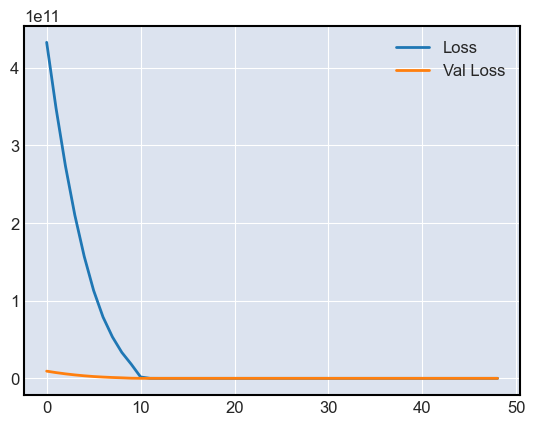

In [63]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'][1:], label='Loss')
ax.plot(history.history['val_loss'][1:], label='Val Loss')
ax.legend()

In [65]:
results = model.predict(x_test)
results[:15]

array([[2764.4626],
       [2870.0476],
       [2898.3953],
       [2789.53  ],
       [2750.4006],
       [2781.0535],
       [2686.3967],
       [2739.7786],
       [2780.0027],
       [2738.159 ],
       [2743.8406],
       [2876.8943],
       [2872.4001],
       [2806.8542],
       [2753.8425]], dtype=float32)

(100, 2)
accuracy 7.000000000000001%


/tmp/ipykernel_7457/2034842860.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


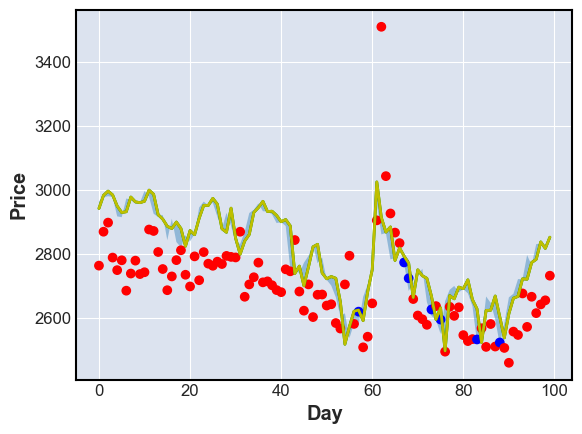

In [66]:
def evaluation(predictions, actual):
    aux = [True if actual[x][0] <= predictions[x] <= actual[x][1] or actual[x][1] <= predictions[x] <= actual[x][0] else False for x in range(len(predictions))]
    print(f'accuracy {(aux.count(True)/len(aux))*100}%')
    fig, ax = plt.subplots()
    ax.fill_between(range(len(predictions)), [x[0] for x in actual], [x[1] for x in actual], alpha=0.4)
    ax.plot(range(len(predictions)), [x[0] for x in actual], color='g')
    ax.plot(range(len(predictions)), [x[0] for x in actual], color='y')
    ax.scatter(range(len(predictions)), predictions, c=np.array([[0., 0., 1.] if actual[i][0] <= predictions[i] <= actual[i][1] or actual[i][1] <= predictions[i] <= actual[i][0] else [1., 0., 0.] for i in range(len(predictions))]))
    ax.set_xlabel('Day')
    ax.set_ylabel('Price')
    fig.show()
print(y_test.shape)
evaluation(results, y_test)

## Recurrent Neural Network

In [69]:
def week_batch_generator(raw_df):
    df_x = raw_df[:-1]
    df_y = np.array([(x[0]+x[3])/2 for x in raw_df[1:]])
    x_batch = df_x[:-(len(df)%5)].reshape((len(df_x)//5, 5, 5)) #quitamos los dias de la semana sueltos para tener batches de cada semana (5 dias)
    y_batch = df_y[:-(len(df)%5)].reshape(len(df_y)//5, 5)
    return x_batch[:-100], y_batch[:-100], x_batch[100:]

x_train, y_train = week_batch_generator(raw_df.to_numpy())
x_test
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(786, 5, 5) (786, 5) (100, 5, 5) (100, 5)


In [75]:
inputs = keras.layers.Input(shape=(x_train.shape[1:]))
x = keras.layers.LSTM(4, activation='relu' , return_sequences=True)(inputs)
x = keras.layers.LSTM(6, activation='relu' , return_sequences=True)(x)
x = keras.layers.LSTM(3, activation='relu' , return_sequences=False)(x)
output = keras.layers.Dense(1, activation="linear")(x)
model = keras.Model(inputs=inputs, outputs=output, name="v1.0")
model.summary()

Model: "v1.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 5, 5)]            0         
                                                                 
 lstm_24 (LSTM)              (None, 5, 4)              160       
                                                                 
 lstm_25 (LSTM)              (None, 5, 6)              264       
                                                                 
 lstm_26 (LSTM)              (None, 3)                 120       
                                                                 
 dense_15 (Dense)            (None, 1)                 4         
                                                                 
Total params: 548
Trainable params: 548
Non-trainable params: 0
_________________________________________________________________


In [77]:
tf.random.set_seed(7)
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
)
history = model.fit(
    x_train[:-100], y_train[:-100],
    validation_data=(x_train[-100:], y_train[-100:]), 
    batch_size=5, epochs=50, shuffle=False, 
    callbacks=[
        keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    ]
)

Epoch 1/50
138/138 [==============================] - 6s 17ms/step - loss: 406808.1250 - val_loss: 1418222.7500
Epoch 2/50
138/138 [==============================] - 2s 14ms/step - loss: 405101.7500 - val_loss: 1415016.3750
Epoch 3/50
138/138 [==============================] - 2s 14ms/step - loss: 403517.1562 - val_loss: 1411888.6250
Epoch 4/50
138/138 [==============================] - 2s 14ms/step - loss: 401960.5938 - val_loss: 1408796.5000
Epoch 5/50
138/138 [==============================] - 2s 14ms/step - loss: 400419.3125 - val_loss: 1405725.8750
Epoch 6/50
138/138 [==============================] - 2s 13ms/step - loss: 398889.0625 - val_loss: 1402671.5000
Epoch 7/50
138/138 [==============================] - 2s 13ms/step - loss: 397367.4062 - val_loss: 1399629.5000
Epoch 8/50
138/138 [==============================] - 2s 14ms/step - loss: 395853.2812 - val_loss: 1396598.2500
Epoch 9/50
138/138 [==============================] - 2s 14ms/step - loss: 394345.6875 - val_loss: 13935

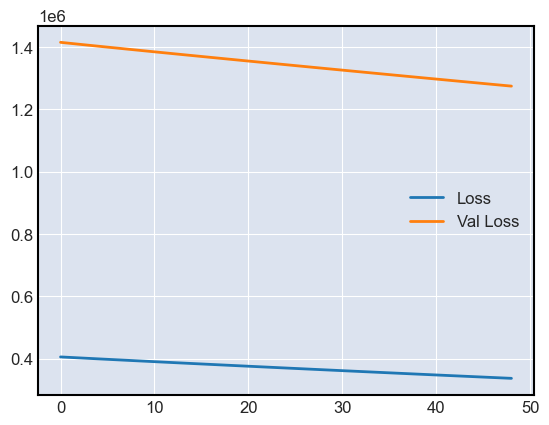

In [78]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'][1:], label='Loss')
ax.plot(history.history['val_loss'][1:], label='Val Loss')
ax.legend()